# Notebook 17: Energy-based Generative Models for MNIST


## Learning Goal

The goal of this notebook is to familiarize readers with various energy-based generative models including: Restricted Boltzmann Machines (RBMs) with Gaussian and Bernoulli units, Deep Boltzmann Machines (DBMs), as well as techniques for training these model including contrastive divergence (CD) and persistent contrastive divergence (PCD). We will also discuss how to generate new examples (commonly called fantasy particles in the ML literature). The notebook also introduces the [Paysage](https://github.com/drckf/paysage) package from [UnLearn.AI](https://unlearn.ai/) for quickly building and training these models.

## Overview

In this notebook, we study the MNIST dataset using generative models. 

Let us adopt a different perspective on the MNIST dataset. Generative models, as the name suggests, are useful to generate brand new data (images) by learning how to imitate the ones from a given data set. If you wish, they can be regarded as a kind of "creative ML". This is achieved by extracting/learning a set of features which represent the backbone of the entire data and are thus definitive for the particular dataset. These features are encoded in the weights of the model. 

Mathematically speaking, generative models are designed and trained to learn an approximation for the probability distribution that generated the data. Intuitively, this task is much more complex and sophisticated than the image recognition task. Therefore, we shall approach the problem in a number of steps of increasing complexity. For a more detailed discussion on the theory, we invite the reader to check out Secs. XV and XVI of the review.

Below, we analyze four different generative models: the Hopfield Model, a Restricted Boltzmann Machine (RBM), a regularized RMB with sparse weights, and a Deep Boltzmann Machine (DBM). In all these cases, we first set up and train the models. After that, we compare the results. Last, we open up the black box of each model and visualize a set of features it learned. 

## Setting up Paysage

In this notebook, we use an open-source `python` package for energy-based models, called [paysage](https://github.com/drckf/paysage). Paysage requires `python>3.5`; we recommend using the package with an [Anaconda](https://www.continuum.io/downloads) environment.

To install paysage: 

* clone or download the [github repo](https://github.com/drckf/paysage)
* activate an Anaconda3 environment
* navigate to the directory which contains the paysage files
* and execute
```
pip install .
```

Documentation for paysage is available under [https://github.com/drckf/paysage/tree/master/docs](https://github.com/drckf/paysage/tree/master/docs).

By default, computations in paysage are performed using `numpy`/`numexpr`/`numba` on the CPU. If you have installed [PyTorch](https://pytorch.org), then you can switch to the `pytorch` backend by changing the setting in `paysage/backends/config.json` to `pytorch`. 

Let us set up the required packages for this notebook by importing paysage.

In [1]:
from __future__ import print_function, division
import os
import paysage
import numpy as np
from paysage.models.model import Model # model constructor
from paysage import optimizers # optimizer
from paysage.layers import BernoulliLayer, GaussianLayer # layers
from paysage.batch import DataShuffler, HDFBatch # data handler
from paysage.fit import ProgressMonitor, SequentialMC, SGD, LayerwisePretrain, pcd
from paysage.schedules import PowerLawDecay # hyperparameter schedule
from paysage.models.model_utils import State
from paysage.penalties import l1_penalty # regularization
# fix random seed to ensure deterministic behavior
np.random.seed(137)
paysage.backends.set_seed(137) 

## Obtaining the MNIST dataset

As we mentioned in the introduction, we use the MNIST dataset of handwritten digits to study the Hopfield model and various variants of RBMs. 

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ nuances of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. There are $10$ categories in the problem, corresponding to the ten digits. In previous notebooks, we formulated a classification task for the MNIST dataset, and studied it using discriminative supervised learning: Logistic Regression and Deep Neural Networks. 


This dataset can be fetched using paysage from the web as an `HDF5` file. For this, you should

* navigate to the directory in which you cloned/downloaded paysage
* navigate further into the `mnist/` directory which contains the file `download_mnist.py`.
* from the terminal, run the command 
```
python3 mnist/download_mnist.py
```

This file contains keys `train/images`, `train/labels`, `test/images`, and `test/labels` and is compressed to about 15 Mb in size.

As our first step, we will set up the paths to the data and shuffle the dataset. The shuffled dataset will not be compressed (for faster reading during training) so it will be about 56 Mb in size.

_Why shuffle the data?_ - Training with stochastic gradient descent means we will be using small minibatches of data (maybe 50 examples) to compute the gradient at each step. If the data have an order, then the estimates for the gradients computed from the minibatches will be biased. Shuffling the data ensures that the gradient estimates are unbiased (though still noisy).

In [2]:
paysage_path = os.path.dirname(os.path.dirname(paysage.__file__))
mnist_path = os.path.join(paysage_path, "mnist", "mnist.h5")
shuffled_mnist_path = os.path.join(paysage_path, "mnist", "shuffled_mnist.h5")

print("path to mnist data:")
print(mnist_path)

if not os.path.exists(mnist_path):
    raise IOError("{} does not exist. run mnist/download_mnist.py to fetch from the web".format(mnist_path))
    
if not os.path.exists(shuffled_mnist_path):
    paysage.batch.DataShuffler(mnist_path, shuffled_mnist_path, complevel=0).shuffle()

path to mnist data:
/Users/mbukov/paysage/mnist/mnist.h5


### Processing the Data

Next, we create a `data` generator, which splits the data into a training and validation sets, and separates them into minibatches of size `batch_size`. Before we begin training, we set `data` into `train` `mode`. 

To monitor the progress of performance metrics during training, we define the variable `performance` which tells Paysage to measure the reconstruction error from the validation set. Possible metrics include the reconstruction error (used in this example) and metrics related to difference in energy of random samples and samples from the model (see [`metrics.md`](https://github.com/drckf/paysage/blob/master/docs/metrics.md) in Paysage documentation for a complete list).

In [3]:
##### set up minibatch data generator
# shuffle data if running for the first time
if not os.path.exists(shuffled_mnist_path):
    DataShuffler(mnist_path,shuffled_mnist_path,complevel=0).shuffle()
# batch size
batch_size=100 
# create data generator object with minibathces
data=HDFBatch(shuffled_mnist_path,'train/images', batch_size,
        transform=paysage.preprocess.binarize_color,train_fraction=0.95)
# reset the data generator in training mode
data.reset_generator(mode='train') 
# the reconstruction error will be computed from the validation set
performance=ProgressMonitor(data,metrics=['ReconstructionError'])

### Setting up a Hopfield Model

Having loaded and preprocessed the data, we now move on to construct a `hopfield` model. To do this, we use the `Model` class and with a visible `BernoulliLayer` and a hidden `GaussianLayer`. Note that the visible layer has the same size as the input data samples, which is can be read off `data.ncols`. The number of hidden units is `num_hidden_units`. We also set the mean and variance of the Gaussian layer to zero and unity, respectively (the notation here is inspired by the terminology in Variational Auto Encoders).

We choose to train the model with the `Adam` optimizer. To ensure convergence, we attenuate the `learning_rate` hyperparameter according to a `PowerLawDecay` schedule: `learning_rate`$(t)$ =`initial`$/(1 +$ `coefficient`$\;\times\; t)$. It will prove convenient to define the function `Adam_optimizer()` for this purpose.

In [4]:
##### create hopfield model
# hidden units
num_hidden_units=200 
# set up the model
hopfield=Model([BernoulliLayer(data.ncols), # visible layer
                GaussianLayer(num_hidden_units) # hidden layer
                ])
# set mean and standard deviation of hidden layer to to 0 and 1, respectively
hopfield.layers[1].set_fixed_params(['loc', 'log_var'])
# set up an optimizer method (ADAM in this case)
def ADAM_optimizer(initial,coefficient):
    # define learning rate attenuation schedule
    learning_rate=PowerLawDecay(initial=initial,coefficient=coefficient)
    # return optimizer object
    return optimizers.ADAM(stepsize=learning_rate)

### Compiling and Training a Model in Paysage

Next, we have compile the model. First, we initialize a `model` using the `initialize` function attribute which accepts the `data` as a required argument. We choose the initialization routine `glorot`, see discussion in Sec. XVI of the review. Second, we define an optimizer calling the function `Adam_optimizer()` defined above, and store the object under the name `opt`. To define a Monte Carlo `sampler`, we use the method `from_batch` of the `SequentialMC` class, parsing the `model` and the `data`. Last, we create an `SGD` object called `trainer` to train the model using Persistent Contrastive Divergence (`pcd`) with a fixed number of `monte_carlo_steps`. We can also `monitor` the reconstruction error during training. Last, we train the model in epochs (see variable `num_epochs`), calling the `train()` method of `trainer`. These steps are universal for shallow generative `model`'s, and it is convenient to combine them in the function `train_model()`.

In [5]:
# define function to compile and train model
num_epochs=20 # training epochs
monte_carlo_steps=1 # number of MC sampling steps
def train_model(model,num_epochs,monte_carlo_steps,performance):
        # make a simple guess for the initial parameters of the model
        model.initialize(data,method='glorot_normal')
        # set optimizer
        opt=ADAM_optimizer(1E-2,1.0)
        # set up a Monte Carlo sampler
        sampler=SequentialMC.from_batch(model,data)
        # use persistent contrastive divergence to fit the model
        trainer=SGD(model,data,opt,num_epochs,sampler, 
                    method=pcd,mcsteps=monte_carlo_steps,monitor=performance)
        # train model
        trainer.train()
# train hopfield model
train_model(hopfield,num_epochs,monte_carlo_steps,performance)

End of epoch 0: 
-ReconstructionError: 8.069056
Epoch took 15.30 seconds

End of epoch 1: 
-ReconstructionError: 7.577994
Epoch took 16.28 seconds

End of epoch 2: 
-ReconstructionError: 7.552461
Epoch took 10.63 seconds

End of epoch 3: 
-ReconstructionError: 7.844871
Epoch took 11.19 seconds

End of epoch 4: 
-ReconstructionError: 8.018479
Epoch took 10.03 seconds

End of epoch 5: 
-ReconstructionError: 8.166762
Epoch took 10.75 seconds

End of epoch 6: 
-ReconstructionError: 8.342621
Epoch took 12.84 seconds

End of epoch 7: 
-ReconstructionError: 8.028865
Epoch took 11.37 seconds

End of epoch 8: 
-ReconstructionError: 8.276211
Epoch took 11.44 seconds

End of epoch 9: 
-ReconstructionError: 8.080429
Epoch took 10.79 seconds

End of epoch 10: 
-ReconstructionError: 8.047049
Epoch took 11.98 seconds

End of epoch 11: 
-ReconstructionError: 7.978387
Epoch took 10.57 seconds

End of epoch 12: 
-ReconstructionError: 7.812917
Epoch took 12.48 seconds

End of epoch 13: 
-ReconstructionEr

## More Generative Models

We can easily create a Bernoulli RBM and train it using the functions defined above as follows:

In [6]:
##### Bernoulli RBM
rbm = Model([BernoulliLayer(data.ncols), # visible layer
             BernoulliLayer(num_hidden_units) # hidden layer
            ])
# train Bernoulli RBM
train_model(rbm,num_epochs,monte_carlo_steps,performance)

End of epoch 0: 
-ReconstructionError: 9.175511
Epoch took 8.79 seconds

End of epoch 1: 
-ReconstructionError: 8.500314
Epoch took 9.49 seconds

End of epoch 2: 
-ReconstructionError: 8.221111
Epoch took 8.94 seconds

End of epoch 3: 
-ReconstructionError: 7.975316
Epoch took 10.81 seconds

End of epoch 4: 
-ReconstructionError: 7.721550
Epoch took 9.66 seconds

End of epoch 5: 
-ReconstructionError: 7.548157
Epoch took 9.35 seconds

End of epoch 6: 
-ReconstructionError: 7.635749
Epoch took 8.94 seconds

End of epoch 7: 
-ReconstructionError: 7.395990
Epoch took 9.30 seconds

End of epoch 8: 
-ReconstructionError: 7.245435
Epoch took 9.04 seconds

End of epoch 9: 
-ReconstructionError: 7.178277
Epoch took 8.68 seconds

End of epoch 10: 
-ReconstructionError: 7.114680
Epoch took 10.25 seconds

End of epoch 11: 
-ReconstructionError: 7.036240
Epoch took 8.61 seconds

End of epoch 12: 
-ReconstructionError: 7.024932
Epoch took 8.90 seconds

End of epoch 13: 
-ReconstructionError: 7.0144

Constructing a Bernoulli RBM with L1 regularization is also straightforward in Paysage, using the `add_penalty` method which accepts a dictionary as an input.

In [7]:
##### Bernoulli RBM with L1 regularizer
rbm_L1 = Model([BernoulliLayer(data.ncols), # visible layer
                BernoulliLayer(num_hidden_units) # hidden layer
                ])
# add an L1 penalty to the weights
rbm_L1.weights[0].add_penalty({'matrix':l1_penalty(1E-3)})
# train Bernoulli RBM with L1 regularizer
train_model(rbm_L1,num_epochs,monte_carlo_steps,performance)

End of epoch 0: 
-ReconstructionError: 9.316187
Epoch took 18.66 seconds

End of epoch 1: 
-ReconstructionError: 8.583783
Epoch took 18.88 seconds

End of epoch 2: 
-ReconstructionError: 8.353323
Epoch took 15.61 seconds

End of epoch 3: 
-ReconstructionError: 8.214540
Epoch took 15.27 seconds

End of epoch 4: 
-ReconstructionError: 7.859962
Epoch took 16.42 seconds

End of epoch 5: 
-ReconstructionError: 7.766531
Epoch took 16.36 seconds

End of epoch 6: 
-ReconstructionError: 7.572670
Epoch took 16.21 seconds

End of epoch 7: 
-ReconstructionError: 7.461546
Epoch took 17.15 seconds

End of epoch 8: 
-ReconstructionError: 7.324730
Epoch took 17.70 seconds

End of epoch 9: 
-ReconstructionError: 7.416895
Epoch took 19.32 seconds

End of epoch 10: 
-ReconstructionError: 7.209484
Epoch took 18.90 seconds

End of epoch 11: 
-ReconstructionError: 7.204119
Epoch took 17.71 seconds

End of epoch 12: 
-ReconstructionError: 7.233026
Epoch took 16.06 seconds

End of epoch 13: 
-ReconstructionEr

To define a deep Boltzmann machine (DBM), we just add more layers, and an L1 penalty for every layer.

Recalling the essential trick with layer-wise pre-training to prepare the weights of the DBM, we define a `pretrainer` as an object of the `LayerwisePretrain` class (see code snippet below). This results in a slight modification of the function `train_model`.

In [8]:
##### Deep Boltzmann Machine
# set up the model
dbm = Model([BernoulliLayer(data.ncols), # visible layer
             BernoulliLayer(num_hidden_units), # hidden layer 1
             BernoulliLayer(num_hidden_units) # hidden layer 2
            ])
# add an L1 penalty to the weights
for weight in dbm.weights:
    weight.add_penalty({'matrix':l1_penalty(1e-3)})
# add pre-training 	
def train_model(model, data, num_epochs, monte_carlo_steps, performance):
    """
    Train a model.

    Args:
        model (BoltzmannMachine)
        data (Batch)
        num_epochs (int)
        monte_carlo_steps (int)
        performance (ProgressMonitor)

    Returns:
        None

    """
    is_deep = model.num_layers > 2
    # make a simple guess for the initial parameters of the model
    model.initialize(data,method='glorot_normal')
    # set optimizer
    opt = ADAM_optimizer(1E-2,1.0)
    # set up a Monte Carlo sampler
    sampler = SequentialMC.from_batch(model, data)
    if is_deep:
        print("layerwise pretraining")
        pretrainer = LayerwisePretrain(model, data, opt, num_epochs,
                                       method=pcd, mcsteps=monte_carlo_steps,
                                       metrics=['ReconstructionError'])
        pretrainer.train()
        # reset the optimizer using a lower learning rate
        opt = ADAM_optimizer(1E-3,1.0)
    print("use persistent contrastive divergence to fit the model")
    trainer=SGD(model, data, opt, num_epochs, sampler,
                method=pcd, mcsteps=monte_carlo_steps, monitor=performance)
    trainer.train()
# train DBM
train_model(dbm, data, num_epochs, monte_carlo_steps, performance)

layerwise pretraining
training model 0

End of epoch 0: 
-ReconstructionError: 8.406783
Epoch took 17.38 seconds

End of epoch 1: 
-ReconstructionError: 7.957617
Epoch took 22.29 seconds

End of epoch 2: 
-ReconstructionError: 7.601228
Epoch took 23.45 seconds

End of epoch 3: 
-ReconstructionError: 7.362110
Epoch took 20.28 seconds

End of epoch 4: 
-ReconstructionError: 7.100939
Epoch took 17.23 seconds

End of epoch 5: 
-ReconstructionError: 6.965893
Epoch took 9.17 seconds

End of epoch 6: 
-ReconstructionError: 6.825638
Epoch took 11.04 seconds

End of epoch 7: 
-ReconstructionError: 6.755985
Epoch took 11.89 seconds

End of epoch 8: 
-ReconstructionError: 6.770894
Epoch took 11.70 seconds

End of epoch 9: 
-ReconstructionError: 6.617099
Epoch took 12.67 seconds

End of epoch 10: 
-ReconstructionError: 6.489145
Epoch took 10.17 seconds

End of epoch 11: 
-ReconstructionError: 6.438090
Epoch took 11.52 seconds

End of epoch 12: 
-ReconstructionError: 6.437391
Epoch took 12.16 secon

## Visualizing the MNIST Dataset

Let us look at a couple of random examples to get an idea how the data we are dealing with actually looks like.

To do this, we define the function  `plot_image_grid()`.

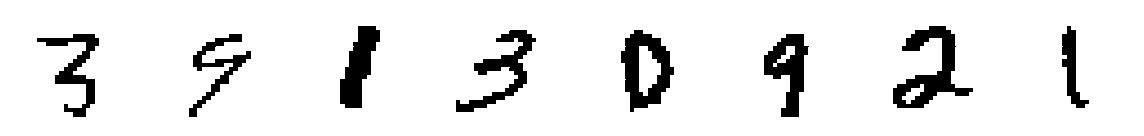

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.cm as cm
import seaborn as sns

# make sure the plots are shown in the notebook

def plot_image_grid(image_array, shape, vmin=0, vmax=1, cmap=cm.gray_r, row_titles=None):
    array = paysage.backends.to_numpy_array(image_array)
    nrows, ncols = array.shape[:-1]
    f = plt.figure(figsize=(2*ncols, 2*nrows))
    grid = gs.GridSpec(nrows, ncols)
    axes = [[plt.subplot(grid[i,j]) for j in range(ncols)] for i in range(nrows)]
    for i in range(nrows):
        for j in range(ncols):
            sns.heatmap(np.reshape(array[i][j], shape),
                ax=axes[i][j], cmap=cmap, cbar=False, vmin=vmin, vmax=vmax)
            axes[i][j].set(yticks=[])
            axes[i][j].set(xticks=[])

    if row_titles is not None:
        for i in range(nrows):
            axes[i][0].set_ylabel(row_titles[i], fontsize=36)
            
    plt.tight_layout()
    plt.show(f)
    plt.close(f)
    

image_shape = (28, 28) # 28x28 = 784 pixels in every image
num_to_plot = 8 # of data points to plot

examples = data.get(mode='train') # shape (batch_size, 784)

example_plot = plot_image_grid(np.expand_dims(examples[:num_to_plot], 0), 
                               image_shape, vmin=0, vmax=1)

### Reconstructions

Having trained our models, let us see how they perform by computing some reconstructions from the validation data. 

Recall that a reconstruction ${\bf v'}$ of a given data point ${\bf x}$ is computed in two steps: (i) we fix the visible layer ${\bf v}={\bf x}$ to be the data, and use MC sampling to find the state of the hidden layer ${\bf h}$ which maximizes the probability distribution $p({\bf h}\vert{\bf v})$, (ii) fixing the same obtained state ${\bf h}$, we find the reconstruction of the visible layer ${\bf v'}$ which maximizes the probability $p({\bf v'}\vert{\bf h})$. In the case of a DBM, the forward pass continues until we reach the last of the hidden layers, and the backward pass goes in reverse. 

To compute reconstructions, we define a MC `sampler` based on the trained `model`. The stating point form the MC sampler is set using the `set_state()` method. To compute reconstructions, we need to keep the probability distribution encoded in the `model` fixed which is done with the help of the `deterministic_iteration` function method, that takes in its first argument the number of passes (`1` for a single ${\bf v}\to {\bf h}\to {\bf v'}$ pass), and the state of the sampler `sampler.state` as required arguments. We can combine these steps in the function `compute_reconstructions`.

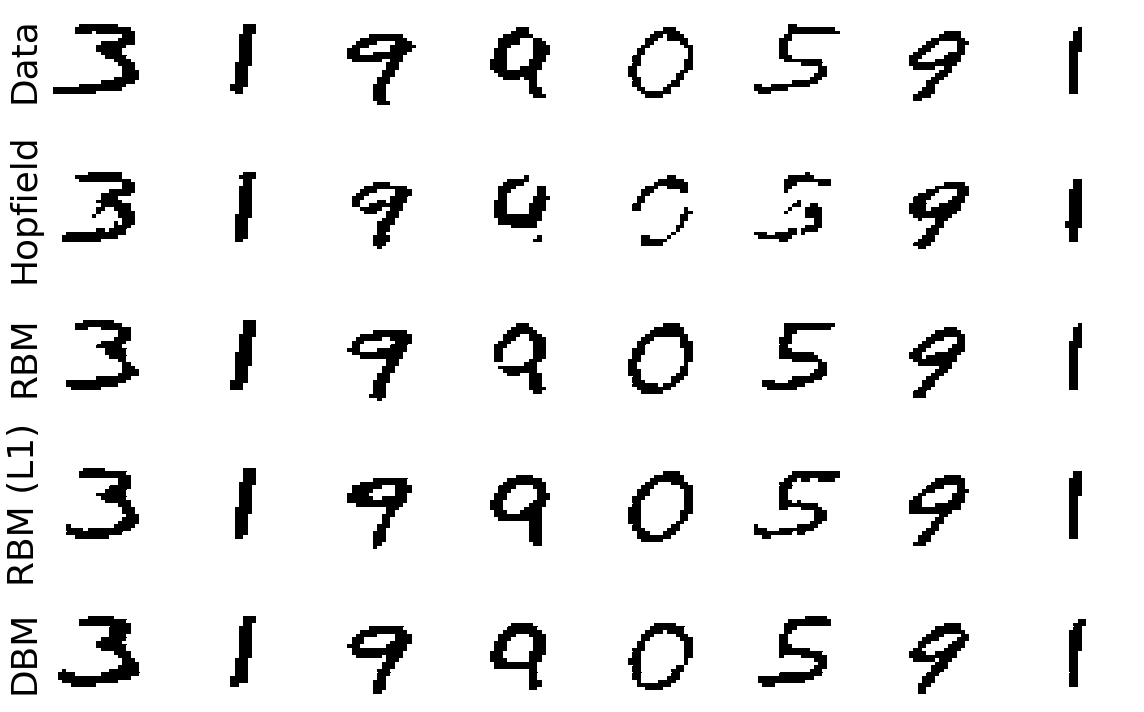

In [10]:
##### compute reconstructions
def compute_reconstructions(model, data):
    """
    Computes reconstructions of the input data.
    Input v -> h -> v' (one pass up one pass down)

    Args:
        model: a model
        data: a tensor of shape (num_samples, num_visible_units)

    Returns:
        tensor of shape (num_samples, num_visible_units)

    """
    # WHAT DOES THIS DO?
    data_state=State.from_visible(data,model)
    # define MC sampler
    sampler=SequentialMC(model)
    # define a starting point for MC sampler
    sampler.set_state(data_state) 
    # compute reconstructions
    recons=model.deterministic_iteration(1,sampler.state).units[0]
    #
    return paysage.backends.to_numpy_array(recons)


examples = data.get(mode='validate') # shape (batch_size, 784)
data.reset_generator(mode='validate') # reset the generator to the beginning of the validation set

hopfield_reconstructions = compute_reconstructions(hopfield, examples[:num_to_plot])
rbm_reconstructions = compute_reconstructions(rbm, examples[:num_to_plot])
rbm_L1_reconstructions = compute_reconstructions(rbm_L1, examples[:num_to_plot])
dbm_reconstructions = compute_reconstructions(dbm, examples[:num_to_plot])

reconstruction_plot = plot_image_grid(
    np.array([examples[:num_to_plot], 
                 hopfield_reconstructions, 
                 rbm_reconstructions, 
                 rbm_L1_reconstructions,
                 dbm_reconstructions]), 
    image_shape, vmin=0, vmax=1, row_titles=["Data", "Hopfield", "RBM", "RBM (L1)", "DBM"])

### Fantasy Particles

Once we have the trained models ready, we can use MC to draw samples from the corresponding probability distributions, called "fantasy particles". To this end let us draw a `random_sample` from the validation data, and compute the `model_state`. Next, we define a MC `sampler` based on the `model`, and set its state to `model_state`. To compute the fantasy particles, we do layer-wise Gibbs sampling for a total of `n_steps` equilibration steps. The last step (controlled by the boolean `mean_field`) is a final mean-field iteration.

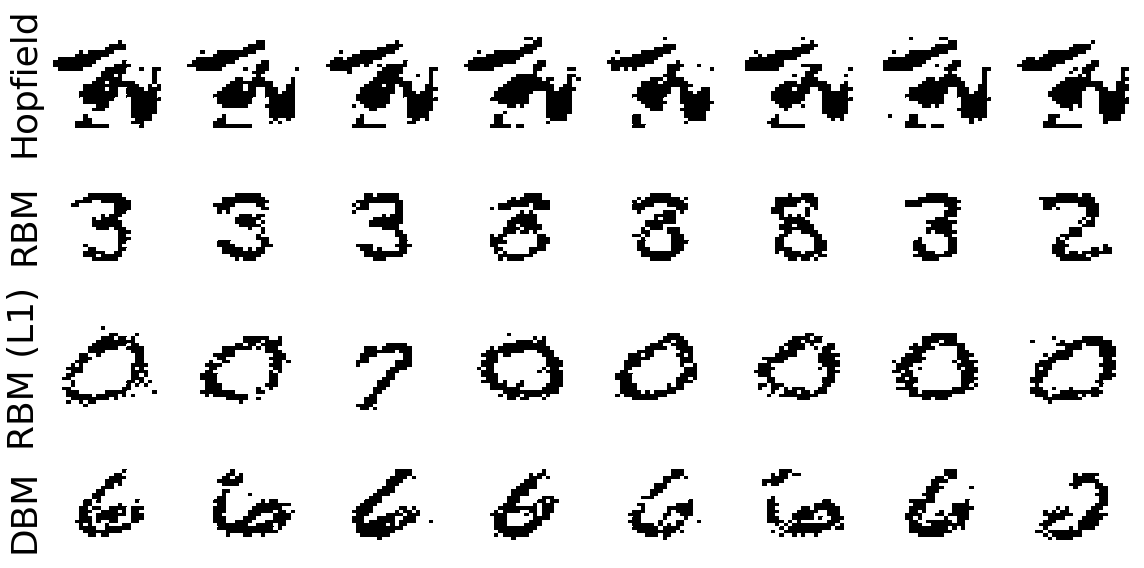

In [11]:
def compute_fantasy_particles(model,data,num_steps,mean_field=True):
    """
    Draws samples from the model using Gibbs sampling Markov Chain Monte Carlo .
    Starts from randomly initialized points. 

    Args:
        model: a model
        data: a tensor of shape (num_samples, num_visible_units)
        num_steps (int): the number of update steps
        mean_field (bool; optional): run a final mean field step to compute probabilities

    Returns:
        tensor of shape (num_samples, num_visible_units)

    """
    # compute random data sample
    random_sample=model.random(data)
    # get model state from visible layer
    model_state=State.from_visible(random_sample,model)
    # define MC sampler
    sampler=SequentialMC(model)
    # change sampler state
    sampler.set_state(model_state)
    # does n_steps forward and backward passes
    sampler.update_state(num_steps) 
    if mean_field: # see Hinton's 2012 paper: trick (practical guide for training)
        fantasy_particles=model.mean_field_iteration(1,sampler.state).units[0]
    else:
        fantasy_particles=sampler.state.units[0]
    #
    return paysage.backends.to_numpy_array(fantasy_particles)


examples = data.get(mode='validate') # shape (batch_size, 784)
data.reset_generator(mode='validate') # reset the generator to the beginning of the validation set

hopfield_fantasy = compute_fantasy_particles(hopfield, examples[:num_to_plot], 100, mean_field=False)
rbm_fantasy = compute_fantasy_particles(rbm, examples[:num_to_plot], 100, mean_field=False)
rbm_L1_fantasy = compute_fantasy_particles(rbm_L1, examples[:num_to_plot], 100, mean_field=False)
dbm_fantasy = compute_fantasy_particles(dbm, examples[:num_to_plot], 100, mean_field=False)

fantasy_plot = plot_image_grid(
    np.array([hopfield_fantasy, 
                 rbm_fantasy, 
                 rbm_L1_fantasy,
                 dbm_fantasy]), 
    image_shape, vmin=0, vmax=1, row_titles=["Hopfield", "RBM", "RBM (L1)", "DBM"])

### De-noising Images

One can use generative models to reduce the noise in images (de-noising). Let us randomly flip a fraction, `fraction_to_flip`, of the black & white bits in the validation data, and use the models defined above to reconstruct (de-noise) the digit images:

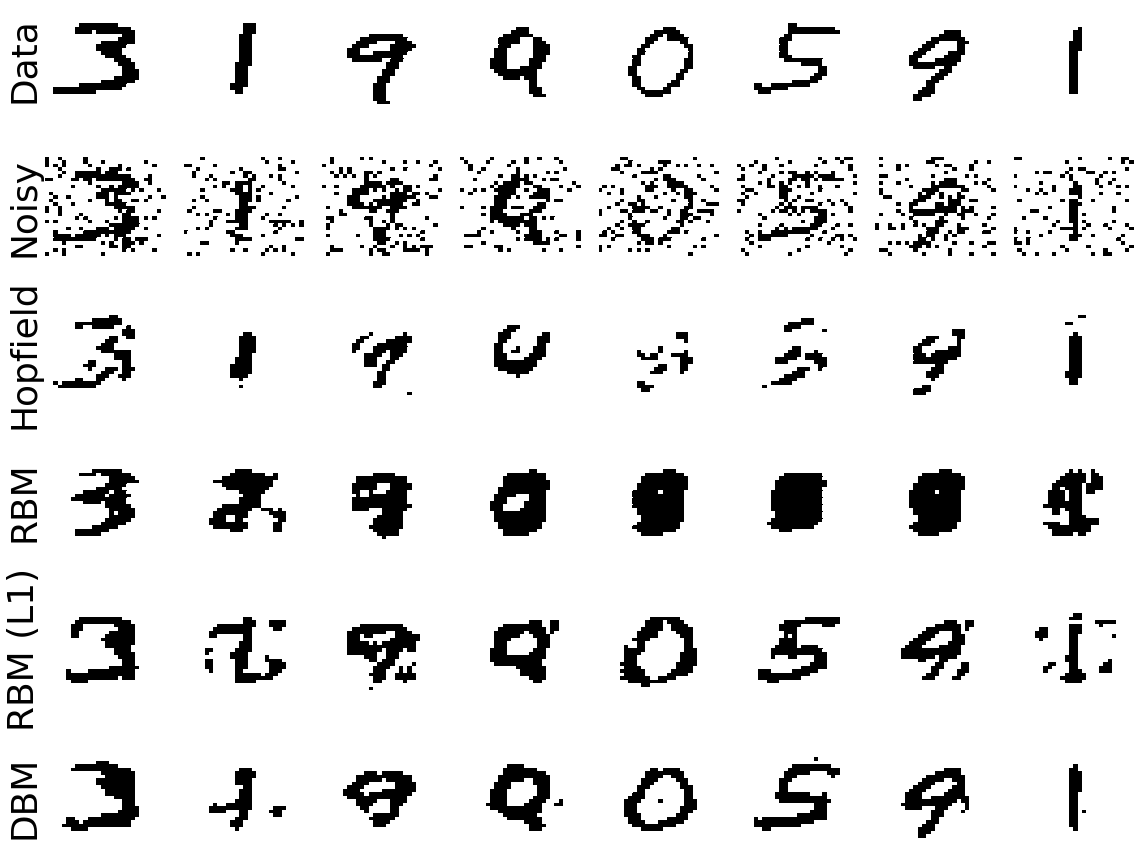

In [12]:
##### denoise MNIST images
# get validation data
examples = data.get(mode='validate') # shape (batch_size, 784)
# reset data generator to beginning of the validation set
data.reset_generator(mode='validate') 
# add some noise to the examples by randomly flipping some pixels 0 -> 1 and 1 -> 0
fraction_to_flip=0.15
# create flipping mask
flip_mask=paysage.backends.rand_like(examples) < fraction_to_flip
# compute noisy data
noisy_data=(1-flip_mask) * examples + flip_mask * (1 - examples)
# define number of digits to display
num_to_display=8
# compute de-noised images
hopfield_denoised=compute_reconstructions(hopfield,noisy_data[:num_to_display])
rbm_denoised=compute_reconstructions(rbm,noisy_data[:num_to_display])
rbm_L1_denoised=compute_reconstructions(rbm_L1,noisy_data[:num_to_display])
dbm_denoised=compute_reconstructions(dbm,noisy_data[:num_to_display])

denoising_plot = plot_image_grid(
    np.array([examples[:num_to_plot], 
                 noisy_data[:num_to_plot], 
                 hopfield_denoised, 
                 rbm_denoised, 
                 rbm_L1_denoised,
                 dbm_denoised]), 
    image_shape, vmin=0, vmax=1, row_titles=["Data", "Noisy", "Hopfield", "RBM", "RBM (L1)", "DBM"])

### Weight Visualization

Let us open up the black box of our generative models now. Below, we show the features learned by the weights of the different models.

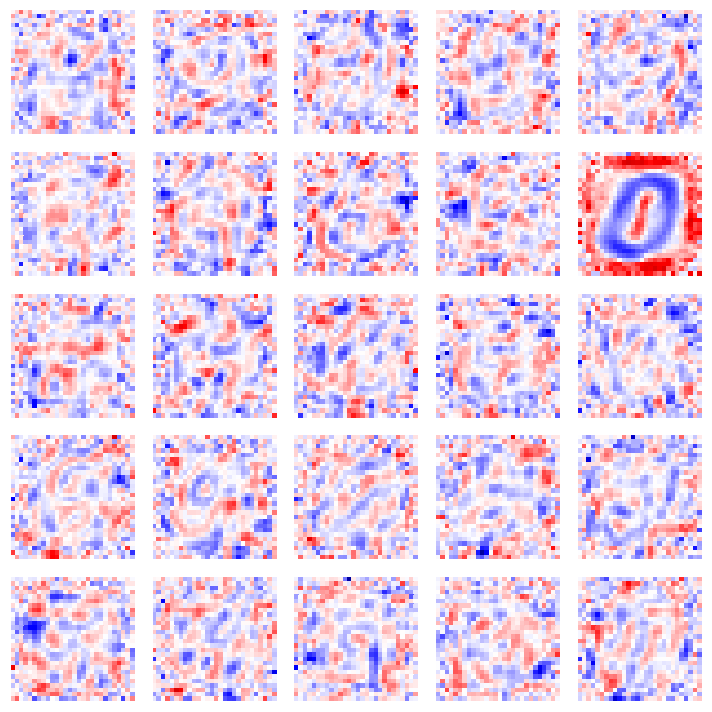

In [13]:
# plot the weights of the hopfield model
hopfield_weights = plot_image_grid(
    paysage.backends.reshape(hopfield.weights[0].W_T()[:25], (5,5,784)), 
    image_shape, 
    vmin=paysage.backends.tmin(hopfield.weights[0].W()), 
    vmax=paysage.backends.tmax(hopfield.weights[0].W()),
    cmap=cm.seismic)

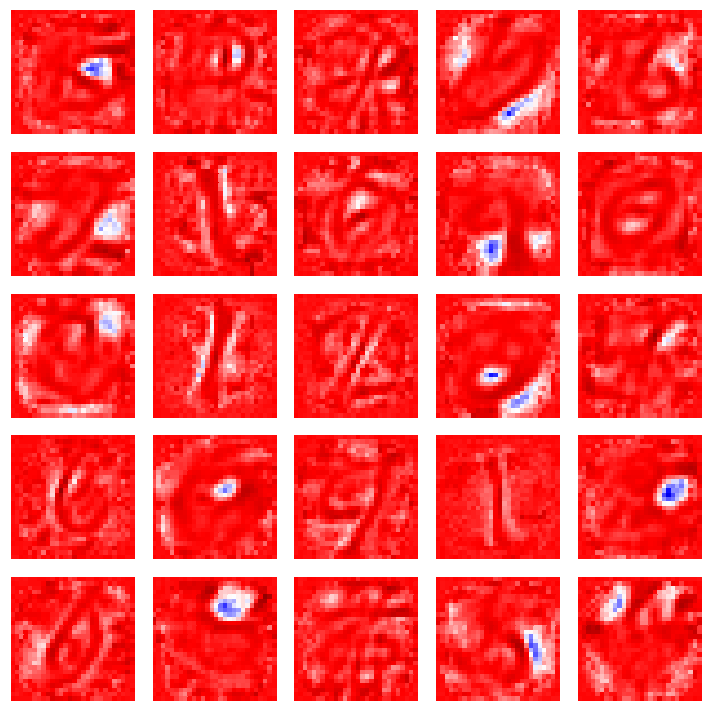

In [14]:
# plot the weights of the RBM
rbm_weights = plot_image_grid(
    paysage.backends.reshape(rbm.weights[0].W_T()[:25], (5,5,784)), 
    image_shape, 
    vmin=paysage.backends.tmin(rbm.weights[0].W()), 
    vmax=paysage.backends.tmax(rbm.weights[0].W()),
    cmap=cm.seismic)

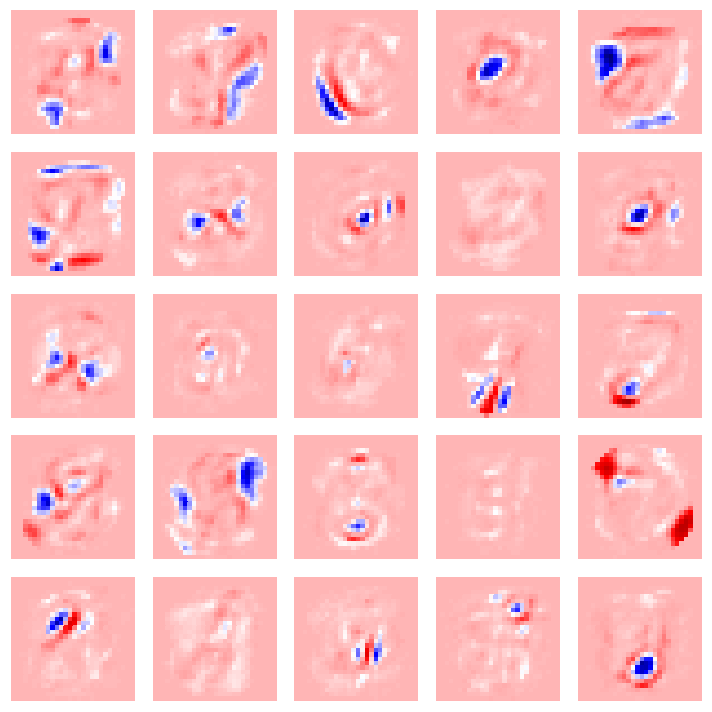

In [15]:
# plot the weights of the L1 regularized RBM
rbmL1_weights = plot_image_grid(
    paysage.backends.reshape(rbm_L1.weights[0].W_T()[:25], (5,5,784)), 
    image_shape, 
    vmin=paysage.backends.tmin(rbm_L1.weights[0].W()), 
    vmax=paysage.backends.tmax(rbm_L1.weights[0].W()),
    cmap=cm.seismic)

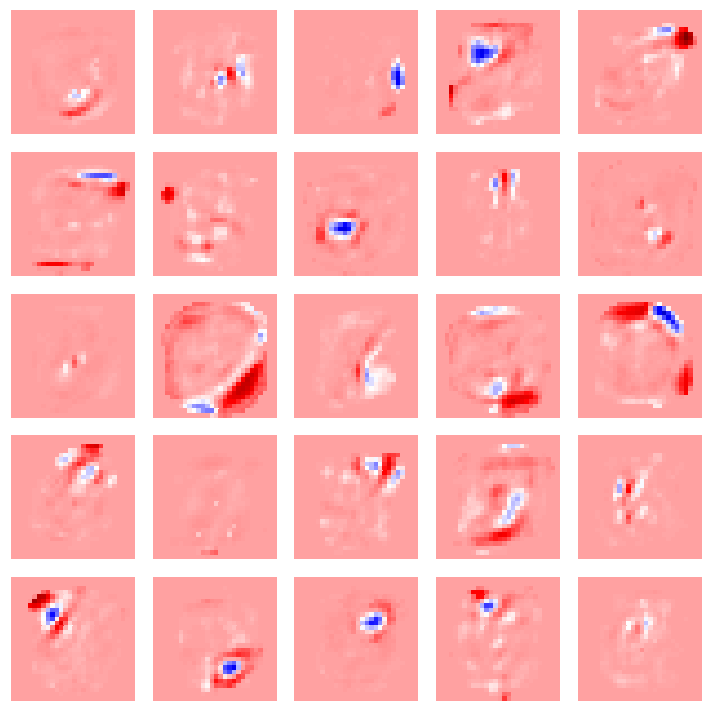

In [16]:
# plot the weights of the first layer of the dbm
dbm_weights = plot_image_grid(
    paysage.backends.reshape(dbm.weights[0].W_T()[:25], (5,5,784)), 
    image_shape, 
    vmin=paysage.backends.tmin(dbm.weights[0].W()), 
    vmax=paysage.backends.tmax(dbm.weights[0].W()),
    cmap=cm.seismic)

In [17]:
data.close() # close the HDF5 store with the MNIST dataset

## Exercises

* Try increasing/decreasing the number of hidden units and study systematically how the performance of the different models changes.
* Look up Paysage's documentation and study the performance for various SGD optimizers.